In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))  # append parent directory to search path
from patterns.visualizer import Visualizer

In [2]:
vis = Visualizer('Spack')

In [3]:
vis.extend_patterns()  # broken!

AttributeError: 'Visualizer' object has no attribute 'set_developer_file_mat'

In [4]:
vis_obj.view_developer_contributions()

AttributeError: 'Visualizer' object has no attribute 'view_developer_contributions'

In [5]:
vis_obj.set_dimensions(10,10)

In [6]:
vis_obj.extend_patterns()

In [7]:
vis_obj.refresh()

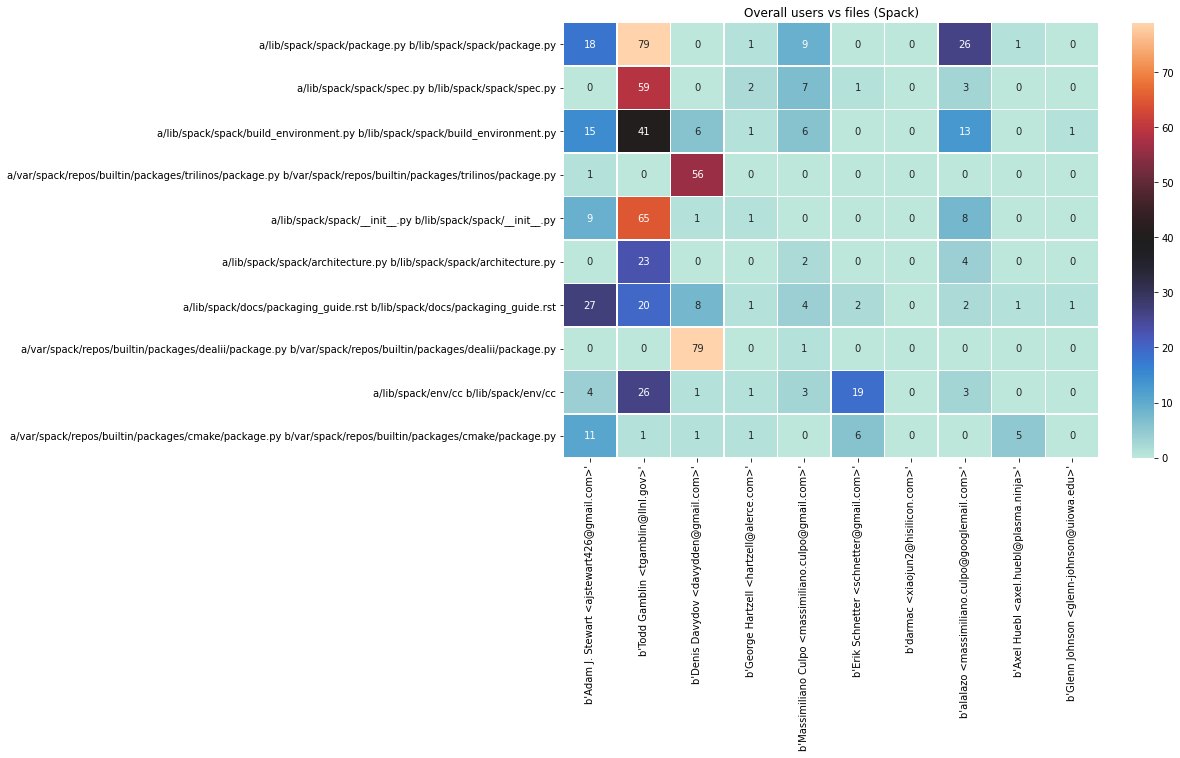

In [8]:
vis_obj.view_developer_file_map()

/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


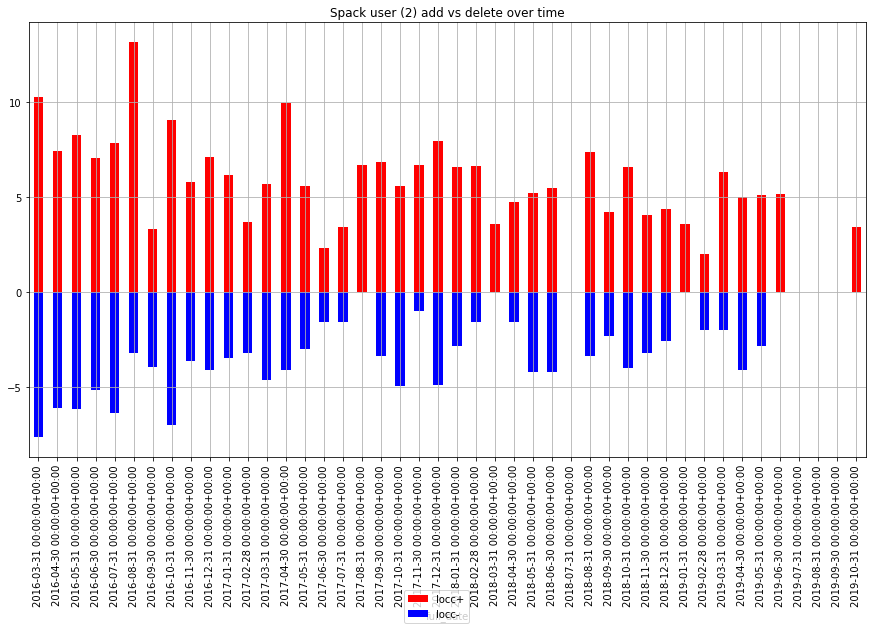

In [9]:
vis_obj.plot_user_add_delete(user_rank=2)

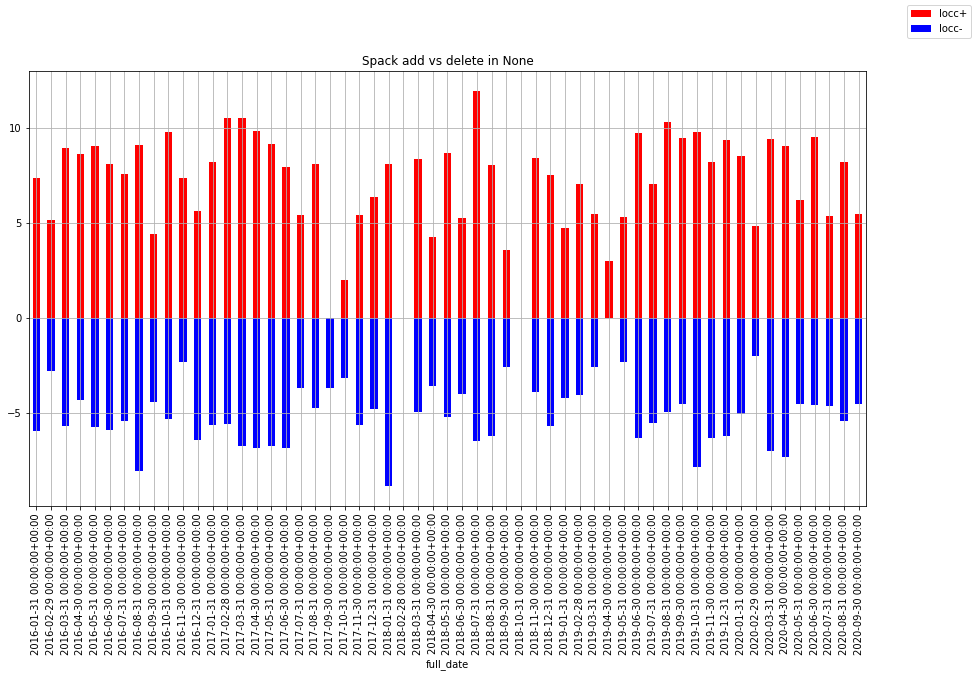

In [10]:
vis_obj.plot_overall_prjct()

In [11]:
vis_obj.reset(2019)

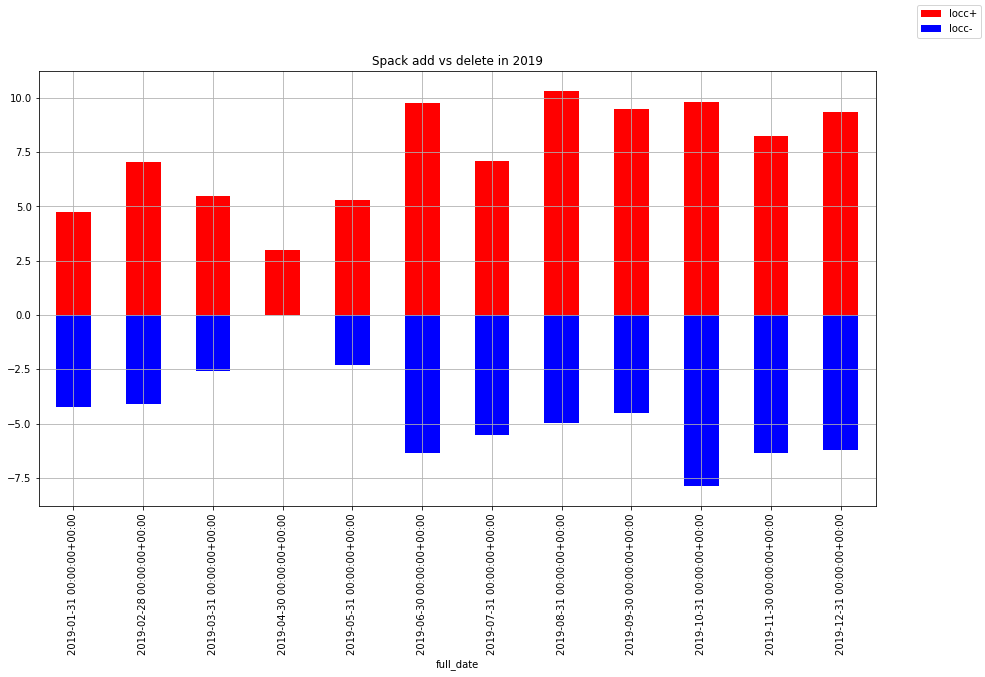

In [12]:
vis_obj.plot_overall_prjct()

In [13]:
vis_obj.reset(2020, 4)

/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


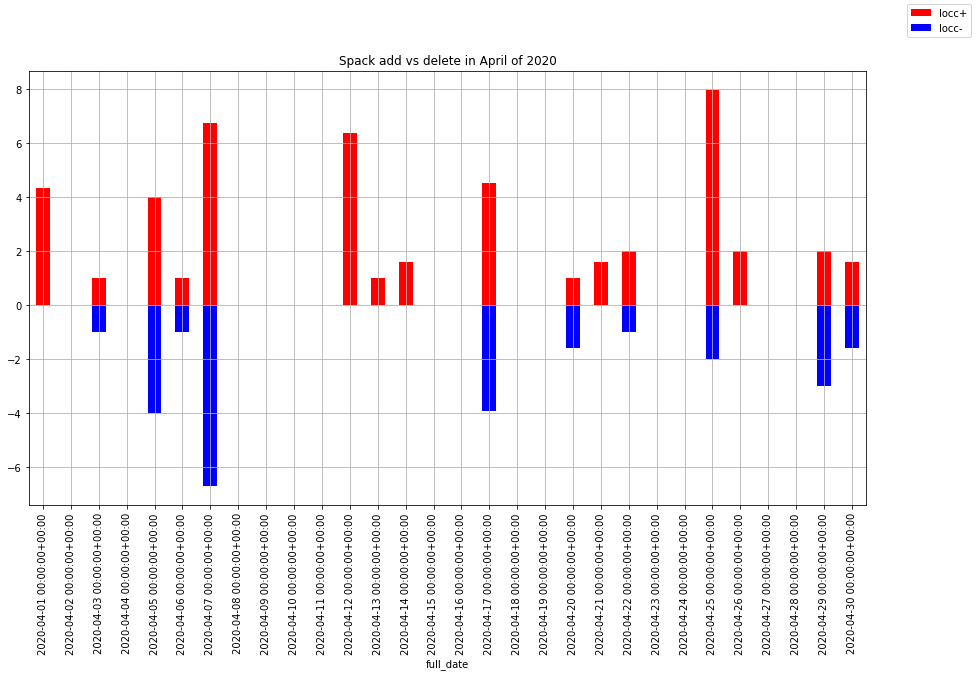

In [14]:
vis_obj.plot_overall_prjct(time_range='month')

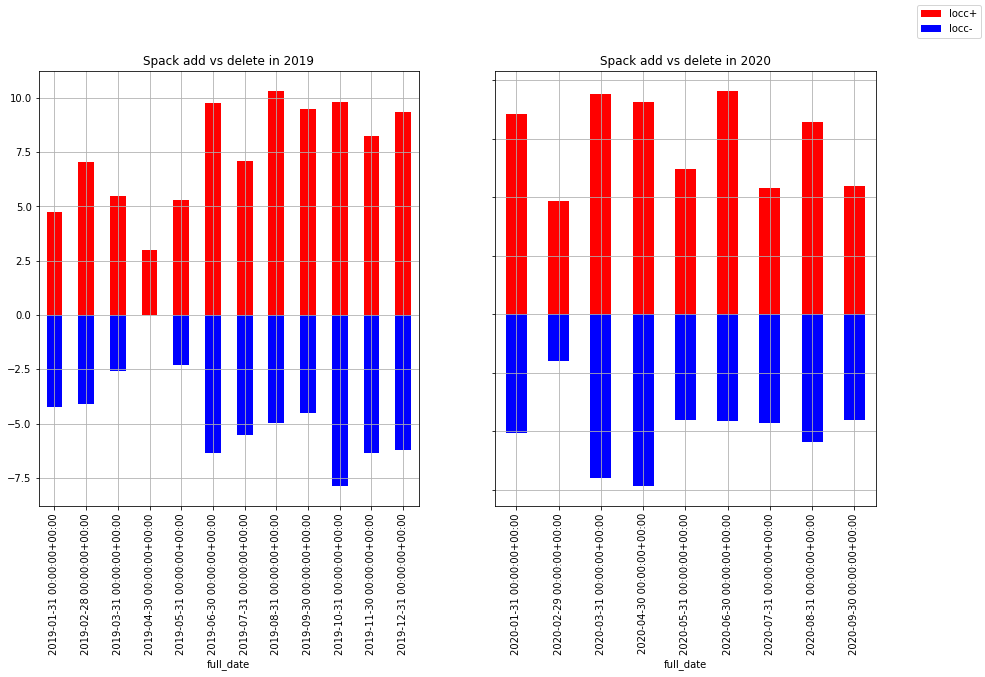

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

In [15]:
vis_obj.plot_proj_y2y(2019, 2020)

In [16]:
vis_obj.reset(2019)

/usr/local/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


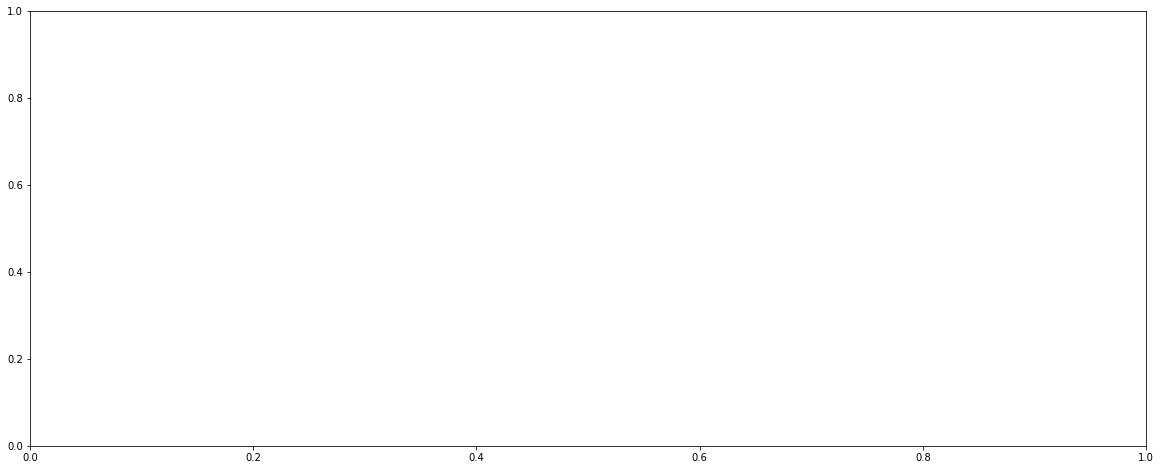

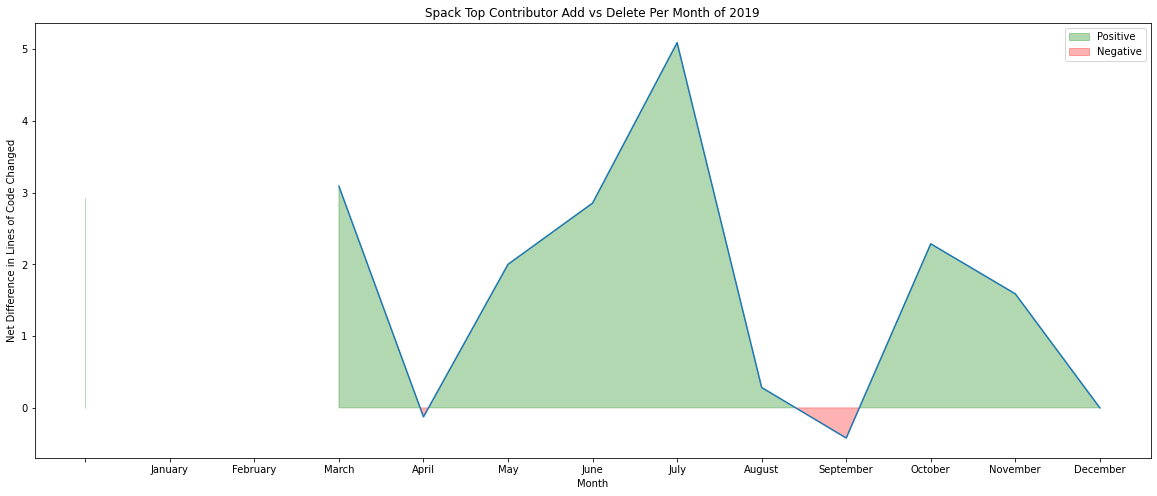

In [17]:
vis_obj.plot_user_add_delete(user_rank=1, style='area')